# Análise qualitativa e Tutorial de diagrama de bifurcação em R

*Este tutorial pressupõe que você leu o [tutorial sobre integração numérica](https://colab.research.google.com/github/renatocoutinho/ode_examples/blob/master/Numerical%20Integration%20Tutorial.ipynb).*


## Explorando o espaço de parâmetros: diagramas de bifurcação

Diagramas de bifurcação representam as soluções (de longo prazo) de um modelo em função de algum parâmetro, cujo efeito queremos investigar. A ideia é que, à medida que esse parâmetro muda, as soluções mudam de forma "bem comportada", e isso nos ajuda a entender melhor o comportamento geral do modelo.

Neste tutorial, vamos estudar um modelo simples de predador-presa (o Rosenzweig-MacArthur), e ver como a quantidade de recursos por presa ($K$) muda a dinâmica.

### O modelo de recursos do consumidor Rosenzweig-MacArthur

Este modelo é expresso como:
$$ \begin{aligned}
\frac{dR}{dt} &= rR \left( 1 - \frac{R}{K} \right) - \frac{a R C}{1+ahR} \\
\frac{dC}{dt} &= \frac{e a R C}{1+ahR} - d C
\end{aligned} $$

#### Soluções do modelo Rosenzweig–MacArthur

Usamos o mesmo método já explicado para integrar este modelo numericamente:

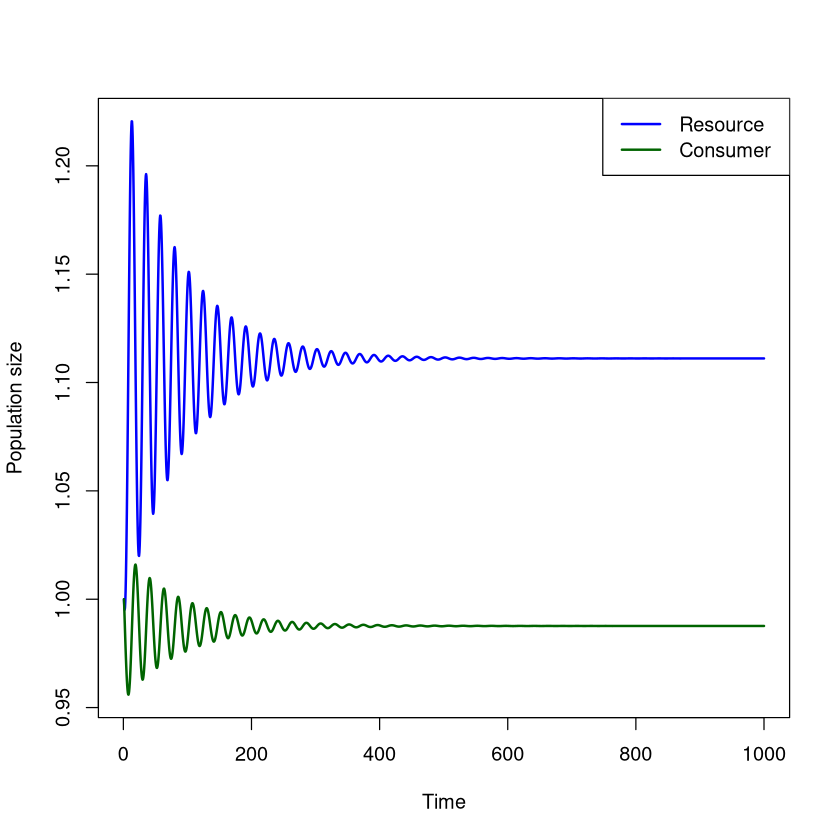

In [1]:
##Carregando bibliotecas
library(deSolve)

### Modelo Rosenzweig-MacArthur###

## Sistema de EDOs a ser integrado
RM <- function(t, y, parms){
    with(as.list(c(y, parms)),
         {
             dR = r*R*(1-R/K) - a*R*C/(1+a*h*R)
             dC = e*a*R*C/(1 + a*h*R) - d*C
             return(list(c(R=dR,C=dC)))
         })
}

##parâmetros
parms1 = c(r=1, K=10, a=1, h=0.1, e=0.1, d=0.1)

## condições iniciais
y0 = c(R=1,C=1)

## rodando a integração numérica do tempo 1 a 1000
out = ode(y=y0, times = seq(from=1, to=1000, by=0.5), func = RM, parms = parms1)

##plotando a solução
    matplot(x=out[,1], y=out[,2:3], type = "l", lwd=2, lty=1,
            col=c("blue", "darkgreen"), xlab="Time", ylab="Population size")
    legend("topright", legend = c("Resource","Consumer"), 
           lty = 1, lwd=2, col=c("blue", "darkgreen"))

#### exigido pelo jupyter
options(jupyter.plot_mimetypes = 'image/png')
####

Para os parâmetros escolhidos acima, a solução de longo prazo (assintótica) é um ponto fixo. Vamos ver isso no espaço de fase, ou seja, o espaço de Predadores ($P$) vs. Presas ($V$). Notamos que as setas estão "circulando", mas sempre apontam para dentro, e assim a trajetória se move em direção ao meio, ao ponto fixo.

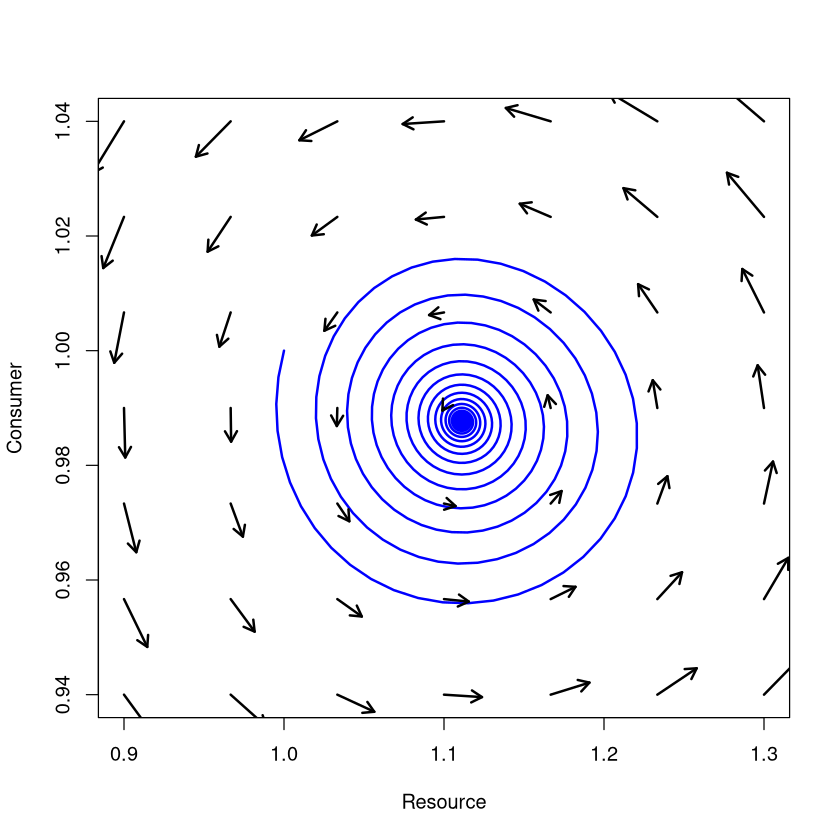

In [2]:

## Espaço de fases e pontos fixos
##primeiro precisamos calcular as coordenadas para os vetores
xs = seq(from=0.9, to=1.3, length.out=7)
ys = seq(from=0.94, to=1.04, length.out=7)
coords = expand.grid(R=xs, C=ys)
## E, em seguida, faça um loop sobre todas as coordenadas para calcular as derivadas nesses pontos
dvs = matrix(NA, ncol=2, nrow=nrow(coords))
for(i in 1:nrow(coords))
    dvs[i,] = unlist(RM(t=1, y = coords[i,], parms = parms1))

## agora plotamos a trajetória
    plot(x=out[,2], y=out[,3], type="l", lwd=2, col="blue",
        xlab="Resource",ylab="Consumer", xlim=c(0.9,1.3), ylim=c(0.94,1.04))
    ## e adicionamos o campo vetorial
    arrows(x0=coords[,1], y0=coords[,2], x1=coords[,1]+dvs[,1]*0.5,
           y1=coords[,2]+dvs[,2]*0.5, length=0.1, lwd=2)


#### Brincando um pouco com os parâmetros...

Aumentando a capacidade de carga $K$ de $10$ para $15$, agora vemos oscilações...

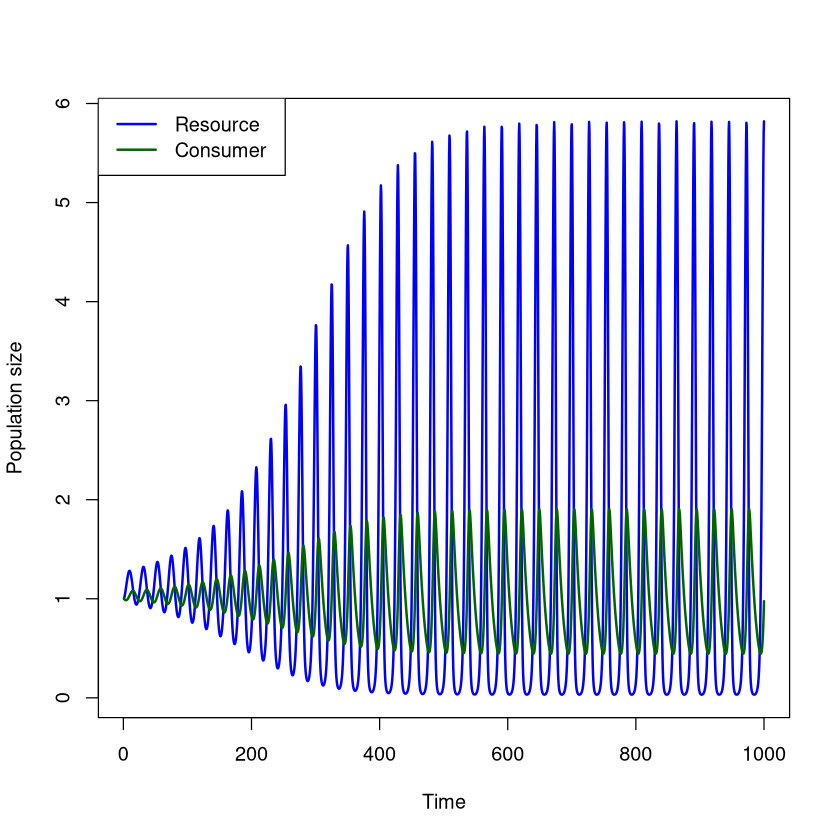

In [3]:
# agora K = 15
parms2 = c(r=1, K=15, a=1, h=0.1, e=0.1, d=0.1)

out2 = ode(y=y0, times = seq(from = 1, to = 1000, by=0.5), func = RM, parms = parms2)

##plotando a solução
    matplot(x=out2[,1], y=out2[,2:3], type = "l", lwd=2, lty=1,col=c("blue", "darkgreen"),
            xlab="Time", ylab="Population size")
    legend("topleft", legend = c("Resource","Consumer"), lty = 1, lwd=2,
           col=c("blue", "darkgreen"))

Olhando novamente para o gráfico de espaço de fase, vemos agora que o fluxo (as setas) de dentro apontam para fora, em direção a um ciclo limite, e as setas de fora apontam para dentro. O ciclo limite corresponde à solução periódica que acabamos de ver.

Warning message in arrows(x0 = coords[, 1], y0 = coords[, 2], x1 = coords[, 1] + :
“zero-length arrow is of indeterminate angle and so skipped”


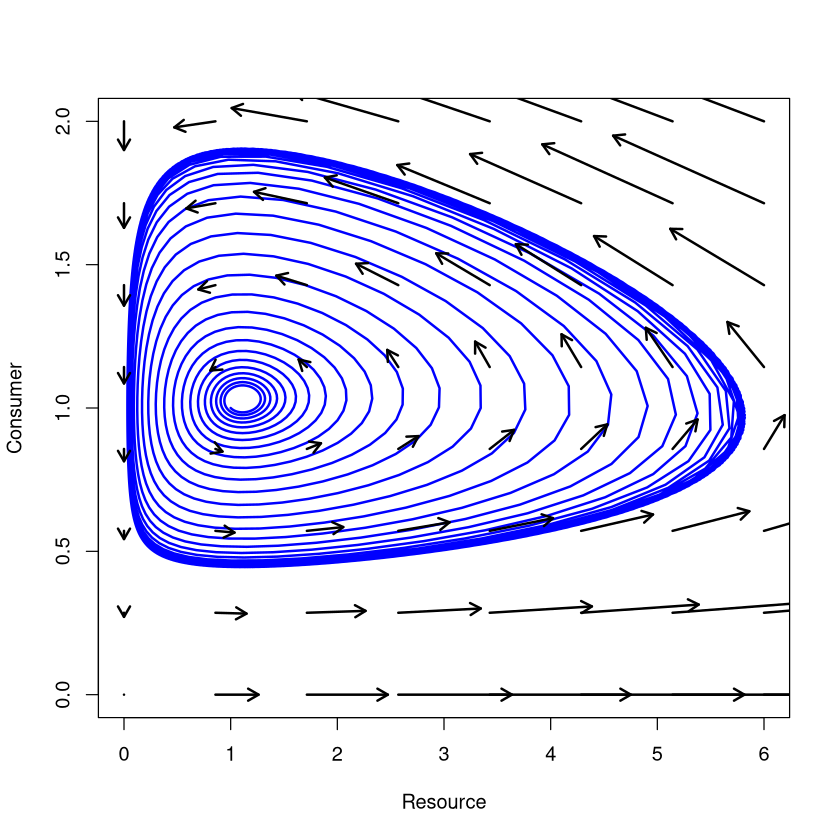

In [4]:
## calculando os vetores novamente
xs = seq(from=0,to=6,length.out=8)
ys = seq(from=0,to=2,length.out=8)
coords = expand.grid(R=xs,C=ys)
dvs = matrix(NA, ncol=2, nrow=nrow(coords))
for(i in 1:nrow(coords))
    dvs[i,] = unlist(RM(t=1, y = coords[i,], parms = parms2))

##A trajetoria
    plot(x=out2[,2],y=out2[,3], type="l", lwd=2, col="blue",
         xlab="Resource", ylab="Consumer", xlim=c(0,6),ylim=c(0,2))
    ##e os vetores
    arrows(x0=coords[,1], y0=coords[,2], x1=coords[,1]+dvs[,1]*0.5,
           y1=coords[,2]+dvs[,2]*0.5, length=0.1, lwd=2)


### O diagrama de bifurcação

Vimos as soluções para dois valores de $K$, $10$ e $15$, então queremos plotá-los como uma função de $K$. No segundo caso, há oscilações, então ao invés de pegar toda a solução, escolhemos apenas o mínimo e o máximo da solução (depois de muito tempo). Quando a solução é um ponto fixo, o mínimo e o máximo devem coincidir.

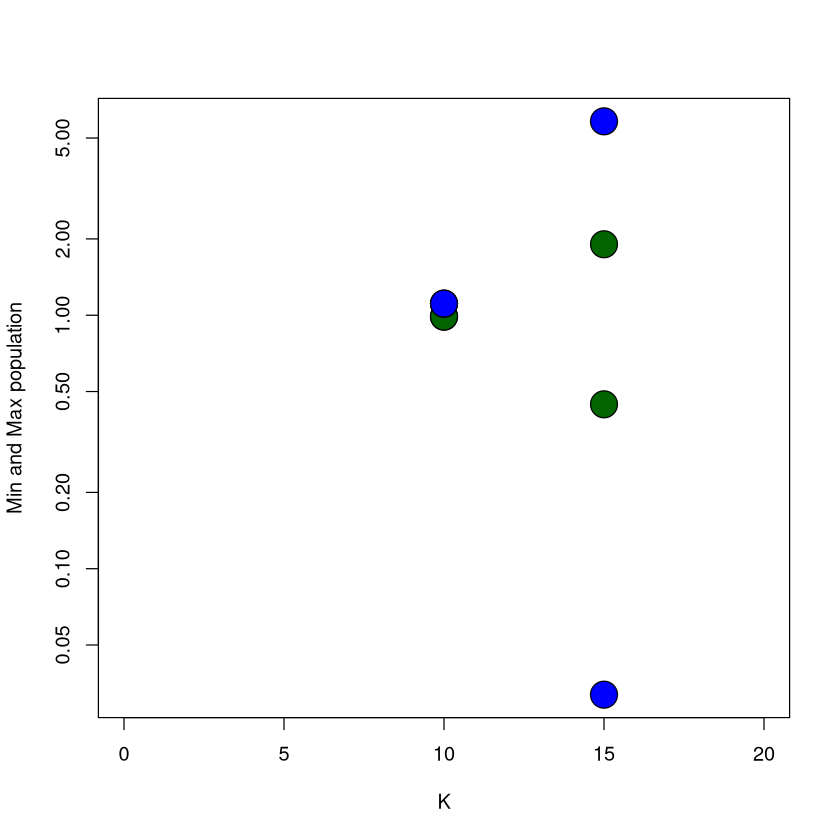

In [5]:
##plotando tamanhos de população mínimo e máximo com diferentes valores de K

##objeto com os números de linha que usaremos para o gráfico a seguir
lines = (nrow(out)-500):nrow(out)

##criando um gráfico vazio
    plot(0.1, type="n", xlim=c(0,20), ylim=range(out2[lines,2:3]), log="y",
         xlab="K", ylab="Min and Max population")

##pontos para o K = 10
    points(x = c(10,10), y = range(out[lines,3]), pch=21,bg="darkgreen", cex=3)
    points(x = c(10,10), y = range(out[lines,2]), pch=21,bg="blue", cex=3)

##pontos para o K = 15
    points(c(15,15), range(out2[lines,3]), pch=21,bg="darkgreen", cex=3)
    points(c(15,15), range(out2[lines,2]), pch=21,bg="blue", cex=3)


Este é um diagrama de bifurcação pouco informativo: ​​tem apenas dois pontos em $K$! Vamos tentar com muitos valores de $K$.

O que acontece quando alteramos a capacidade de carga $K$ de valores muito pequenos para valores muito grandes? Para valores muito pequenos, o recurso não vai sustentar a população consumidora, mas para valores maiores ok $K$, ambas as espécies devem ser beneficiadas... certo?

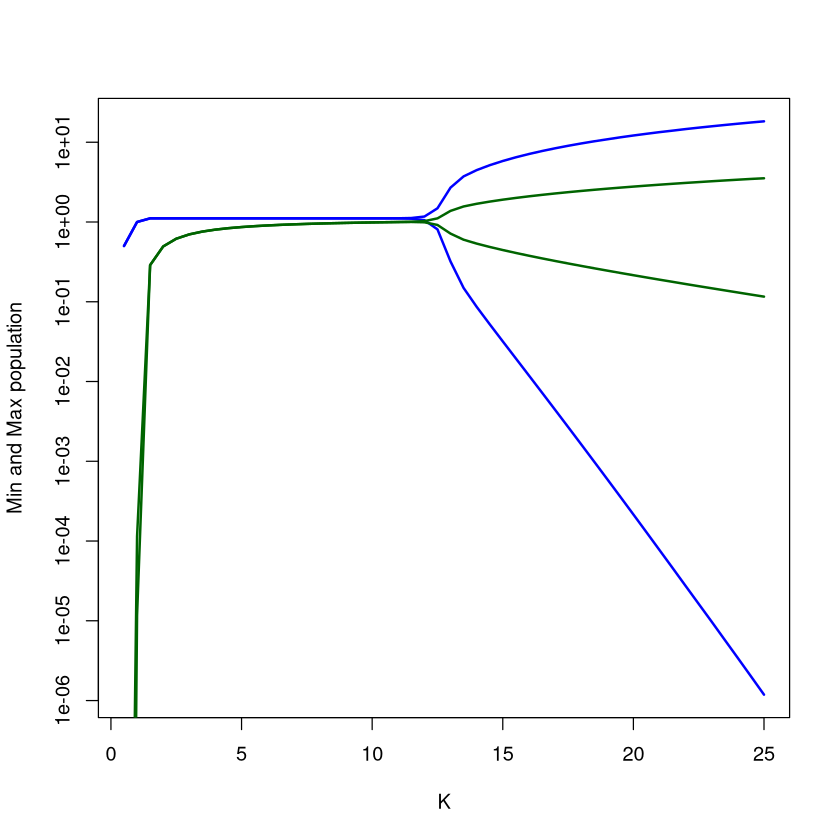

In [6]:
## este bloco calcula soluções para muitos K's, deve levar algum tempo
KK = seq(from = 0.5, to=25, by=0.5)
rminmax = matrix(NA, ncol=2, nrow=length(KK))
cminmax = matrix(NA, ncol=2, nrow=length(KK))

## Faça um loop sobre todos os valores de K e obtenha os tamanhos mínimos e máximos da população

for(i in 1:length(KK)){
    parmsi = c(r=1, K=KK[i], a=1, h=0.1, e=0.1, d=0.1)  
    y0 = c(R=1,C=1)
    out3 = ode(y=y0, times = seq(from = 1, to = 1000, by=0.5), func = RM, parms = parmsi)
    rminmax[i,] = range(out3[(nrow(out3)-500):nrow(out3),2])
    cminmax[i,] = range(out3[(nrow(out3)-500):nrow(out3),3])
}
    plot(x=KK, y=rminmax[,1], type="l", lwd=2, col="blue",ylim=range(rminmax), log="y",
         xlab="K", ylab="Min and Max population")
    points(x=KK, y=rminmax[,2], type="l", lwd=2, col="blue")
    points(x=KK, y=cminmax[,1], type="l", lwd=2, col="darkgreen",ylim=range(rminmax))
    points(x=KK, y=cminmax[,2], type="l", lwd=2, col="darkgreen",ylim=range(rminmax))


Bem, a primeira previsão foi OK (observe que o gráfico acima usa uma escala logarítmica), mas para $K$ altos, os mínimos da oscilação vão para valores muito baixos, então as populações têm alto risco de extinção. Esse fenômeno é o chamado **paradoxo do enriquecimento**.

### Dinâmica dos recursos do consumidor em um ambiente sazonal

Um tipo especial de diagrama de bifurcação pode ser usado quando temos parâmetros que oscilam com o tempo, e queremos ver como isso interage com o sistema. Vamos considerar novamente as equações de Rosenzweig-MacArthur, mas agora fazemos $r$, a taxa de crescimento da presa, oscilar senoidalmente no tempo:

$$ \begin{aligned}
\frac{dR}{dt} &= r(t) R \left( 1 - \frac{R}{K} \right) - \frac{a R C}{1+ahR} \\
\frac{dC}{dt} &= \frac{e a R C}{1+ahR} - d C \\
r(t) &= r_0 (1+\alpha \sin(2\pi t/T))
\end{aligned} $$

Integramos de forma usual:

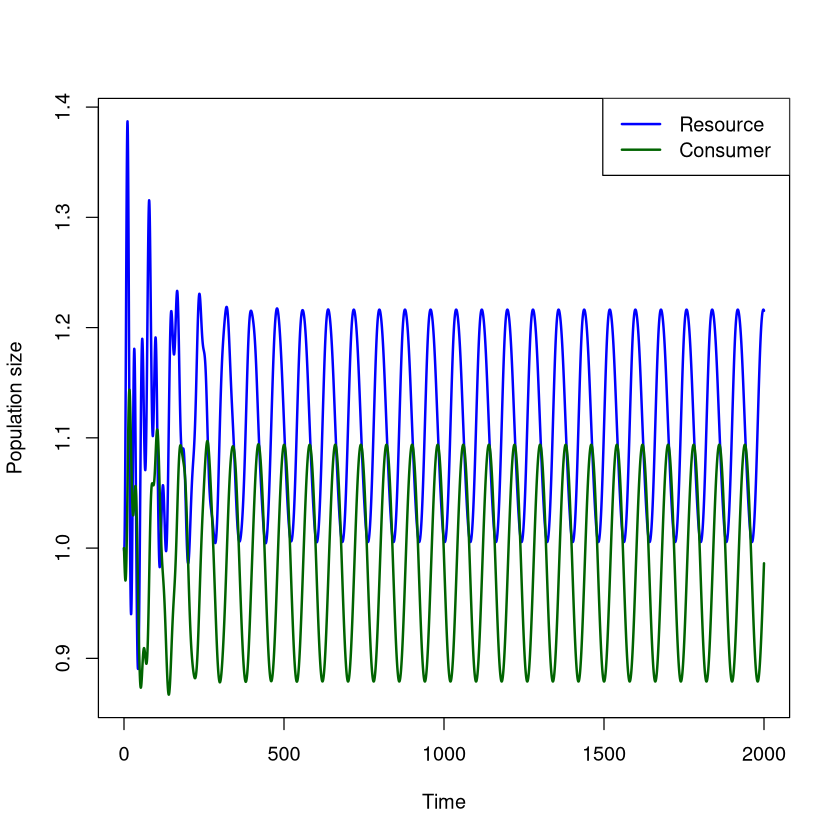

In [7]:
### Dinâmica dos recursos do consumidor em um ambiente sazonal ###
## sequência temporal
time <- seq(0, 2000, by = .5)

## paramêtros: vetor
parameters <- c(r0=1, alpha=0.1, T=80, K=10, a=1, h=0.1, e=0.1, d=0.1)

## condições iniciais: vetor
state <- c(R = 1, C = 1)

## Função R para calcular o valor das derivadas em cada valor de tempo
## Use os nomes das variáveis conforme definido nos vetores acima
RM2 <- function(t, state, parameters){
    with(as.list(c(state, parameters)), {
        r = r0 * (1 + alpha*sin(2*pi*t/T))
        dR = R * ( r*(1 - R/K) - a*C / (1 + a*h*R) )
        dC = e*a*R*C / (1 + a*h*R) - d*C
        return(list(c(dR, dC)))
    })
}

## Integrando com ode
out <- ode(y = state, times = time, func = RM2, parms = parameters)

## plotando
    matplot(x = out[,1], y = out[,2:3], type="l", lwd=2, lty = 1,
            col=c("blue", "darkgreen"), xlab = "Time", ylab = "Population size")
    legend("topright", c("Resource", "Consumer"), lty=1, lwd=2, col=c("blue", "darkgreen"))

Observe que, mesmo com $K$ pequeno, as soluções oscilam devido à oscilação de $r(t)$.

Agora usamos uma ferramenta que é a favorita de todos os tempos dos físicos: o diagrama de ressonância. Funciona exatamente como um diagrama de bifurcação, mas o parâmetro que é alterado é o período (ou frequência) da oscilação externa.

In [ ]:
## Um diagrama de ressonância ##
## Nova sequência de tempo
time <- seq(0, 6000, by = 1)
## Sequência de valores de T
TT <- seq(1, 80, by = 2)

## Uma matriz para armazenar os resultados
results <- matrix(ncol=4, nrow=length(TT),
                  dimnames=list(NULL, c("R.min","R.max","C.min","C.max")))
## Loop sobre TT
for(i in 1:length(TT)){
    parameters <- c(r0=1, alpha=0.1, T=TT[i], K=10, a=1, h=0.1, e=0.1, d=0.1)
    tmp1 <- ode(y = state, times = time, func = RM2, parms = parameters)
    results[i,1:2] <- range(tmp1[1001:nrow(tmp1), 2])
    results[i,3:4] <- range(tmp1[1001:nrow(tmp1), 3])
}

## Plotando
    plot(R.min ~ TT , data=results, type="l", lwd=2, lty = 1,
         col="blue", xlab = "T", ylab = "Min / Max population size",
         log="y", ylim = range(results))
    lines(R.max ~ TT, data=results,  type="l", lwd=2, lty = 1, col=c("blue"))
    lines(C.min ~ TT, data=results,  type="l", lwd=2, lty = 1, col=c("darkgreen"))
    lines(C.max ~ TT, data=results,  type="l", lwd=2, lty = 1, col=c("darkgreen"))   
    legend("topright", c("Resource", "Consumer"), lty=1, lwd=2, col=c("blue", "darkgreen"))

Vemos um pico forte! (lembre-se que esta é uma escala logarítmica). A frequência em que esse pico ocorre é a **frequência de ressonância** do sistema, e está relacionada com a frequência natural do sistema (que existe mesmo quando vai para um ponto fixo com parâmetros constantes!). A oscilação externa excita a frequência natural e aciona ciclos de grande amplitude, como quando empurramos uma gangorra (ou gangorra, o balancín).

## E se eu realmente quiser explorar um espaço de parâmetros de 10 dimensões?

Primeiro: boa sorte. Em segundo lugar, você provavelmente terá que amostrar o espaço, em vez de passar por tudo. O método recomendado para fazer isso são amostras de hipercubo latino ( [Latin Hypercube samples])(http://en.wikipedia.org/wiki/Latin_hypercube_sampling), que usa uma amostragem aleatória de combinaçãoes de parâmetros, garantindo uma boa varredura do espaço de parâmetros. Observe, no entanto, que esse método é uma maneira de amostrar o espaço de parâmetros e fazer estatísticas úteis com ele, portanto, o resultado só fará sentido se você souber interpretar adequadamente os resultados. Dito isso, existem implementações para R e python:

* [R-Cran pse: Parameter space exploration](http://cran.r-project.org/web/packages/pse/)
* [PyDOE: design of experiments for Python](http://pythonhosted.org/pyDOE/randomized.html)